In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
\\
\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
import numpy as np
import casadi
from direct_collocation import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

In [3]:
# Set up a visualization

import matplotlib.pyplot as plt
import matplotlib as mpl



In [4]:
# Acceleration bounds from 
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Sec3

# TODO: Fix lower/upper bounds to sample from functions for x, y.
def lowerbounds(varname, i, k):
    if varname == 'z':
        limits = [-1.0,
                  -1.0,
                  0.0,
                  -np.pi/4,
                  -np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [-5, -np.pi/4] # -1.70
        return limits[i]
    else:
        print("HUGE ERROR: lowerbounds doesn't understand variable named "+varname)
        return -np.inf
    
def upperbounds(varname, i, k):
    if varname == 'z':
        limits = [20.0,
                  1.0,
                  20.0,
                  np.pi/4,
                  np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [0.84, np.pi/4]
        return limits[i]
    else:
        print("HUGE ERROR: upperbounds doesn't understand variable named "+varname)
        return np.inf


In [5]:
car = KinematicBicycleCar(N=30, step=0.05)
        
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost
cost = (car.dae.x[0][2]-5)**2

In [6]:
    
mpcprob = MpcProblem(car.dae,         # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     lowerbounds, # given name of state/control variable, return lower bound
                     upperbounds, # given name of state/control variable, return upper bound
                     N    = 30,   # MPC horizon (steps)
                     step = 0.05, # Time step (seconds)
                     )
uk = [0.0,0.0]

n_runs = 50
x_plan = np.empty((mpcprob.n,n_runs+1))
u_plan = np.empty((mpcprob.m,n_runs))
x_true = np.empty((mpcprob.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    # hack, test changing cost
    if k > 10:
        mpcprob.set_cost(100*car.dae.x[0][2]**2)

#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   5  3.1379104e+01 1.66e+01 2.22e+01  -1.0 1.39e+01    -  1.07e-01 2.05e-01f  1
   6  2.7837304e+01 1.18e+01 1.57e+01  -1.0 1.02e+01    -  1.57e-01 2.88e-01f  1
   7  2.4850622e+01 8.56e+00 1.15e+01  -1.0 6.31e+00    -  2.59e-01 2.73e-01f  1
   8  2.0672578e+01 4.92e+00 6.57e+00  -1.0 2.98e+00    -  4.08e-01 4.26e-01f  1
   9  1.1577620e+01 4.35e-03 1.36e+00  -1.0 1.75e+00    -  4.12e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.4636334e+00 1.02e-03 5.59e-01  -1.0 2.40e+00    -  5.97e-01 6.52e-01f  1
  11  3.6217962e+00 2.63e-03 2.87e-01  -1.0 7.95e+00    -  4.43e-01 5.40e-01f  1
  12  6.1923386e-01 1.74e-03 2.72e-01  -1.7 4.15e+00    -  4.95e-01 9.65e-01f  1
  13  3.3919066e-02 3.02e-04 7.20e-02  -1.7 3.43e+00    -  7.40e-01 1.00e+00f  1
  14  1.0111660e-02 6.63e-06 9.57e-04  -2.5 7.31e-01    -  1.00e+00 1.00e+00h  1
  15  2.7097600e-03 1.66e-06 1.08e-03  -3.8 4.52e-01    -  8.90e-01 1.00e+00h  1
  16  1.3668787e-03 8.37e-07

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  44  9.6468735e+02 1.53e-14 8.19e-06  -8.6 2.25e-06   0.6 1.00e+00 1.00e+00h  1
  45  9.6468735e+02 1.28e-14 7.57e-06  -8.6 1.87e-05  -0.4 1.00e+00 1.00e+00h  1
  46  9.6468735e+02 1.64e-14 6.99e-06  -8.6 1.94e-05  -0.4 1.00e+00 1.00e+00h  1
  47  9.6468735e+02 9.76e-15 4.74e-06  -8.6 1.19e-04  -1.4 1.00e+00 1.00e+00h  1
  48  9.6468735e+02 1.42e-14 4.60e-06  -8.6 1.62e-05  -0.5 1.00e+00 1.00e+00h  1
  49  9.6468735e+02 1.12e-14 4.59e-06  -8.6 7.57e-07   0.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  9.6468735e+02 1.08e-14 4.59e-06  -8.6 2.84e-07   1.2 1.00e+00 1.00e+00h  1
  51  9.6468735e+02 1.93e-14 4.58e-06  -8.6 8.49e-07   0.7 1.00e+00 1.00e+00h  1
  52  9.6468735e+02 1.23e-14 4.58e-06  -8.6 3.18e-07   1.2 1.00e+00 1.00e+00h  1
  53  9.6468735e+02 1.75e-14 4.57e-06  -8.6 9.53e-07   0.7 1.00e+00 1.00e+00h  1
  54  9.6468735e+02 1.42e-14 4.50e-06  -8.6 8.44e-06  -0.3 1.00e+00 1.00e+00h  1
  55  9.6468735e+02 1.17e-14

  23  8.3333320e+02 1.48e-11 1.84e-04  -8.6 3.68e-03  -1.3 1.00e+00 1.00e+00h  1
  24  8.3333320e+02 2.35e-12 2.89e-04  -8.6 8.13e-04  -0.4 1.00e+00 1.00e+00h  1
  25  8.3333320e+02 3.19e-14 4.64e-04  -8.6 6.13e-05   0.9 1.00e+00 1.00e+00h  1
  26  8.3333320e+02 1.83e-13 4.06e-04  -8.6 1.61e-04   0.4 1.00e+00 1.00e+00h  1
  27  8.3333320e+02 5.02e-13 1.10e-03  -8.6 7.56e-04  -0.6 1.00e+00 7.18e-01h  1
  28  8.3333320e+02 2.54e-13 1.61e-03  -8.6 2.55e-03  -1.5 1.00e+00 5.92e-01f  1
  29  8.3333320e+02 1.38e-14 7.56e-05  -8.6 9.09e-04  -1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.3333320e+02 1.40e-14 1.13e-04  -8.6 6.38e-05   0.2 1.00e+00 1.00e+00h  1
  31  8.3333320e+02 4.10e-14 8.08e-05  -8.6 4.10e-04  -0.7 1.00e+00 1.00e+00h  1
  32  8.3333320e+02 2.58e-14 4.82e-05  -8.6 7.34e-04  -1.2 1.00e+00 1.00e+00h  1
  33  8.3333320e+02 4.10e-13 2.19e-05  -8.6 3.00e-03  -2.1 1.00e+00 1.00e+00h  1
  34  8.3333320e+02 1.25e-14

   1  6.9637951e-01 2.59e+01 3.83e+01  -1.0 5.46e+01    -  2.28e-03 9.07e-02f  1
   2  1.6788009e+00 2.49e+01 3.69e+01  -1.0 3.70e+01    -  3.72e-02 3.67e-02f  1
   3  7.8621779e+00 2.23e+01 3.30e+01  -1.0 2.42e+01    -  5.51e-02 1.05e-01f  1
   4  2.3868039e+01 1.94e+01 2.87e+01  -1.0 1.87e+01    -  9.79e-02 1.30e-01h  1
   5  5.9718713e+01 1.61e+01 2.38e+01  -1.0 1.58e+01    -  1.30e-01 1.71e-01h  1
   6  1.2067053e+02 1.28e+01 1.89e+01  -1.0 1.36e+01    -  1.52e-01 2.05e-01h  1
   7  2.0757098e+02 9.68e+00 1.42e+01  -1.0 1.12e+01    -  1.88e-01 2.44e-01h  1
   8  3.2150276e+02 6.71e+00 9.85e+00  -1.0 8.67e+00    -  2.48e-01 3.06e-01h  1
   9  4.5805301e+02 3.98e+00 5.81e+00  -1.0 6.09e+00    -  3.28e-01 4.07e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.9704502e+02 1.71e+00 2.48e+00  -1.0 4.36e+00    -  4.94e-01 5.70e-01h  1
  11  7.1000418e+02 1.17e-01 1.80e-01  -1.0 2.12e+00    -  1.00e+00 9.32e-01h  1
  12  7.1573888e+02 1.09e-05

 111  7.1447904e+02 1.08e-14 5.44e-07  -8.6 1.43e-07   0.6 1.00e+00 1.00e+00h  1
 112  7.1447904e+02 1.15e-14 5.40e-07  -8.6 4.25e-07   0.1 1.00e+00 1.00e+00h  1
 113  7.1447904e+02 1.09e-14 5.39e-07  -8.6 1.59e-07   0.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 113

                                   (scaled)                 (unscaled)
Objective...............:   7.1447904477979660e+02    7.1447904477979660e+02
Dual infeasibility......:   5.3851738649997621e-07    5.3851738649997621e-07
Constraint violation....:   1.0880185641326534e-14    1.0880185641326534e-14
Complementarity.........:   2.5059117622944564e-09    2.5059117622944564e-09
Overall NLP error.......:   5.3851738649997621e-07    5.3851738649997621e-07


Number of objective function evaluations             = 114
Number of objective gradient evaluations             = 114
Number of equality constraint evaluations            = 114
Number of inequality constraint evaluations          = 0
Number of equality constraint Jac

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  6.0749989e+02 1.61e-14 6.28e-06  -8.6 3.12e-05  -0.7 1.00e+00 1.00e+00h  1
  71  6.0749989e+02 1.28e-14 6.18e-06  -8.6 1.15e-05  -0.3 1.00e+00 1.00e+00h  1
  72  6.0749989e+02 1.42e-14 6.14e-06  -8.6 4.28e-06   0.2 1.00e+00 1.00e+00h  1
  73  6.0749989e+02 1.42e-14 6.02e-06  -8.6 1.26e-05  -0.3 1.00e+00 1.00e+00h  1
  74  6.0749989e+02 1.59e-14 5.98e-06  -8.6 4.69e-06   0.1 1.00e+00 1.00e+00h  1
  75  6.0749989e+02 1.24e-14 5.96e-06  -8.6 1.75e-06   0.5 1.00e+00 1.00e+00h  1
  76  6.0749989e+02 1.84e-14 5.91e-06  -8.6 5.22e-06   0.1 1.00e+00 1.00e+00h  1
  77  6.0749989e+02 1.56e-14 5.50e-06  -8.6 4.37e-05  -0.9 1.00e+00 1.00e+00h  1
  78  6.0749989e+02 1.26e-14 5.36e-06  -8.6 1.60e-05  -0.5 1.00e+00 1.00e+00h  1
  79  6.0749989e+02 1.33e-14 5.30e-06  -8.6 5.92e-06  -0.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  6.0749989e+02 1.55e-14

  22  5.1177074e+02 7.64e-12 3.04e-05  -8.6 6.77e-03  -2.3 1.00e+00 1.00e+00h  1
  23  5.1177074e+02 4.64e-13 1.32e-04  -8.6 1.72e-04  -0.1 1.00e+00 1.00e+00h  1
  24  5.1177074e+02 3.16e-13 6.60e-05  -8.6 2.58e-04  -0.6 1.00e+00 1.00e+00h  1
  25  5.1177074e+02 1.61e-14 4.47e-05  -8.6 6.55e-05  -0.2 1.00e+00 1.00e+00h  1
  26  5.1177074e+02 1.29e-14 2.42e-05  -8.6 1.07e-04  -0.6 1.00e+00 1.00e+00h  1
  27  5.1177074e+02 1.91e-14 2.24e-05  -8.6 3.69e-05  -0.2 1.00e+00 1.00e+00h  1
  28  5.1177074e+02 1.24e-14 2.17e-05  -8.6 1.08e-04  -0.7 1.00e+00 1.00e+00h  1
  29  5.1177074e+02 1.71e-14 2.15e-05  -8.6 4.00e-05  -0.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.1177074e+02 1.53e-14 2.04e-05  -8.6 1.14e-04  -0.7 1.00e+00 1.00e+00h  1
  31  5.1177074e+02 1.32e-14 2.01e-05  -8.6 4.21e-05  -0.3 1.00e+00 1.00e+00h  1
  32  5.1177074e+02 1.49e-14 2.00e-05  -8.6 1.57e-05   0.1 1.00e+00 1.00e+00h  1
  33  5.1177074e+02 1.32e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  21  2.8583327e+02 8.90e-12 8.00e-05  -8.6 5.94e-03  -1.9 1.00e+00 1.00e+00h  1
  22  2.8583327e+02 8.19e-13 1.10e-04  -8.6 3.82e-04  -0.5 1.00e+00 1.00e+00h  1
  23  2.8583327e+02 3.51e-13 3.11e-04  -8.6 5.60e-04  -1.0 1.00e+00 7.33e-01h  1
  24  2.8583327e+02 1.08e-14 1.33e-04  -8.6 6.51e-05   0.3 1.00e+00 1.00e+00f  1
  25  2.8583327e+02 1.33e-14 4.71e-05  -8.6 6.91e-05  -0.2 1.00e+00 1.00e+00h  1
  26  2.8583327e+02 2.43e-14 3.82e-05  -8.6 5.04e-04  -1.1 1.00e+00 1.00e+00h  1
  27  2.8583327e+02 2.10e-13 1.89e-05  -8.6 2.25e-03  -2.1 1.00e+00 1.00e+00h  1
  28  2.8583327e+02 5.00e-14 8.96e-06  -8.6 1.20e-03  -2.1 1.00e+00 1.00e+00h  1
  29  2.8583327e+02 2.05e-14 7.79e-07  -8.6 9.37e-04  -3.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.8583327e+02 1.63e-14 1.09e-07  -8.6 1.47e-04  -3.1 1.00e+00 1.00e+00h  1
  31  2.8583327e+02 1.17e-14 1.85e-07  -8.6 1.47e-06  -0.9 1.00e+00 1.00e+00h  1
  32  2.8583327e+02 9.26e-15

   3  7.7754804e+00 1.96e+01 2.91e+01  -1.0 1.43e+01    -  1.15e-01 1.77e-01f  1
   4  2.5390221e+01 1.45e+01 2.14e+01  -1.0 1.02e+01    -  1.90e-01 2.62e-01h  1
   5  6.0698986e+01 9.23e+00 1.36e+01  -1.0 7.44e+00    -  2.58e-01 3.62e-01h  1
   6  1.1560775e+02 4.29e+00 6.23e+00  -1.0 4.73e+00    -  3.78e-01 5.36e-01h  1
   7  1.7830306e+02 3.50e-01 5.97e-01  -1.0 2.59e+00    -  7.05e-01 9.18e-01h  1
   8  1.8505717e+02 1.95e-05 1.03e-03  -1.0 6.74e-01    -  1.00e+00 1.00e+00h  1
   9  1.8108217e+02 5.90e-06 7.34e-02  -2.5 1.12e+00    -  7.84e-01 9.92e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8039604e+02 1.47e-06 1.80e-04  -2.5 1.25e+00    -  1.00e+00 1.00e+00f  1
  11  1.8009384e+02 1.14e-06 1.09e-02  -3.8 8.34e-01    -  8.80e-01 1.00e+00f  1
  12  1.8002862e+02 6.56e-07 2.82e-07  -3.8 2.85e-01    -  1.00e+00 1.00e+00f  1
  13  1.8000968e+02 1.42e-07 1.07e-03  -5.7 1.34e-01    -  7.84e-01 8.15e-01f  1
  14  1.8000242e+02 3.87e-08

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

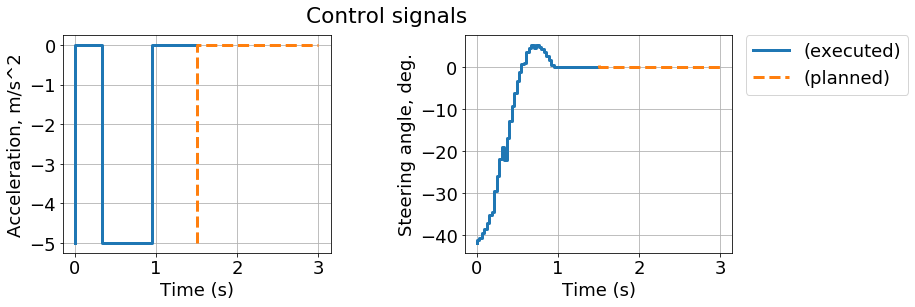

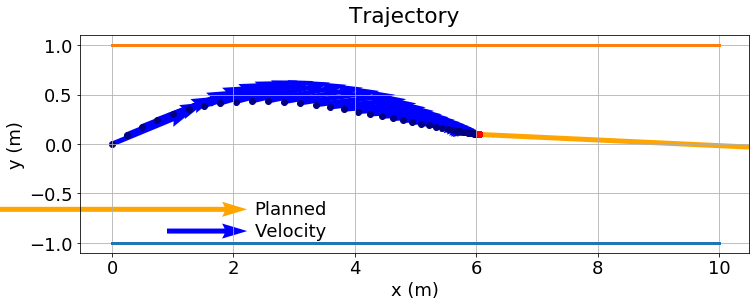

In [7]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
x_ax.plot([0.0,10.0], [-1,-1]) # Road boundary (lower)
x_ax.plot([0.0,10.0], [1,1]) # (upper)
plt.show()

In [8]:
print("Final state:")
print("(x,y):", x_plan[0,-1], x_plan[1,-1])
print("v    :", x_plan[2])

Final state:
(x,y): 6.051021725769933 0.0969575540190803
v    : [5.50000000e+00 5.25000008e+00 5.00000120e+00 4.99999936e+00
 5.00000058e+00 4.99999991e+00 5.00000009e+00 5.00000003e+00
 4.99999965e+00 4.99999985e+00 4.99999970e+00 5.00000048e+00
 4.99999953e+00 4.99999974e+00 4.74999974e+00 4.49999974e+00
 4.24999974e+00 3.99999974e+00 3.74999974e+00 3.49999974e+00
 3.24999974e+00 2.99999974e+00 2.74999974e+00 2.49999974e+00
 2.24999974e+00 1.99999974e+00 1.74999974e+00 1.49999974e+00
 1.24999974e+00 9.99999743e-01 7.49999743e-01 4.99999743e-01
 2.49999744e-01 0.00000000e+00 4.56907996e-05 5.61474146e-05
 5.36662341e-05 5.42067927e-05 5.40621836e-05 5.40738543e-05
 5.40498271e-05 5.40338521e-05 5.40159557e-05 5.39984110e-05
 5.39806995e-05 5.39629390e-05 5.39451022e-05 5.39271952e-05
 5.39092160e-05 5.38911648e-05 5.38730412e-05]


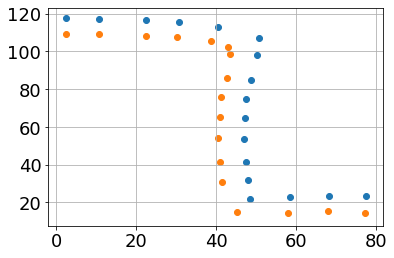

In [9]:
# This is the road to my parents' house, distances in meters.

road_left = np.array([
[2.519, 117.514],
[10.68, 117.192],
[22.303, 116.549],
[30.712, 115.585],
[40.357, 112.691],
[50.744, 107.226],
[50.249, 98.224],
[48.765, 84.721],
[47.529, 74.754],
[47.158, 64.466],
[47.034, 53.535],
[47.529, 41.318],
[48.024, 31.994],
[48.518, 22.028],
[58.41, 22.671],
[68.303, 23.635],
[77.453, 23.153],
])

road_right = np.array([
[2.519, 109.155],
[10.68, 109.316],
[22.427, 108.19],
[30.094, 107.708],
[38.626, 105.297],
[42.83, 102.403],
[43.325, 98.545],
[42.583, 86.007],
[41.222, 75.719],
[40.852, 65.431],
[40.357, 53.856],
[40.852, 41.318],
[41.346, 30.869],
[45.179, 14.955],
[57.916, 14.312],
[68.056, 15.276],
[77.206, 14.312],
])

plt.scatter(road_left[:,0], road_left[:,1])
plt.scatter(road_right[:,0], road_right[:,1])

In [10]:
INITIAL_CONDITIONS = np.array([
    (road_right[0,0] + road_left[0,0])/2.0, # x, car starts in middle of road
    (road_right[0,1] + road_left[0,1])/2.0, #y, same
    11.0, # v, about 25 MPH = 11.17 m/s. This is a bit too fast.
    -np.pi/8, # psi, car is a bit crooked
    0.0 # beta
])

N_ROAD_POINTS = 17


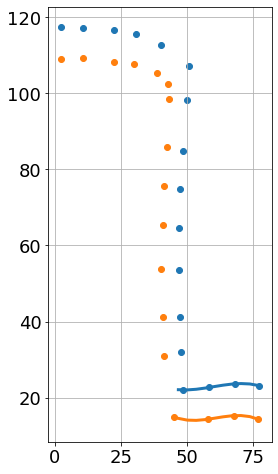

In [11]:
fig1, ax = plt.subplots(1, 1, figsize=(4,8))
ax.scatter(road_left[:,0], road_left[:,1])
ax.scatter(road_right[:,0], road_right[:,1])

left  = np.polynomial.polynomial.Polynomial.fit(road_left[-4:,0], road_left[-4:,1],3)
right = np.polynomial.polynomial.Polynomial.fit(road_right[-4:,0], road_right[-4:,1],3)
limit_start = (road_left[-4] + road_right[-4])/2.0
limit_end = (road_left[-1] + road_right[-1])/2.0


x = np.linspace(limit_start[0], limit_end[0], 10)
ax.plot(x, left(x))
ax.plot(x, right(x))

In [12]:
#
#
#
#
#
#
#
#
#
#

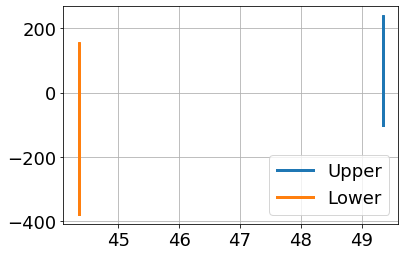

In [13]:
# Acceleration bounds from 
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Sec3

# TODO: Fix lower/upper bounds to sample from functions for x, y.
def lowerbounds(varname, i, k):
    if varname == 'z':
        limits = [limit_start[0]+-5*0.05*10,
                  min(left(k*5*0.05+limit_start[0]), right(k*5*0.05+limit_start[0]))*10,
                  0.0,
                  -np.pi/4,
                  -np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [-1.70, -np.pi/4]
        return limits[i]
    else:
        print("HUGE ERROR: lowerbounds doesn't understand variable named "+varname)
        return -np.inf
    
def upperbounds(varname, i, k):
    if varname == 'z':
        limits = [limit_start[0]+5*0.05*10,
                  max(left(k*5*0.05+limit_start[0]), right(k*5*0.05+limit_start[0]))*10,
                  20.0,
                  np.pi/4,
                  np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [0.84, np.pi/4]
        return limits[i]
    else:
        print("HUGE ERROR: upperbounds doesn't understand variable named "+varname)
        return np.inf

    
upper_bound = np.empty((250,2))
lower_bound = np.empty((250,2))
for k in range(250):
    upper_bound[k,0] = upperbounds('z',0,k)
    upper_bound[k,1] = upperbounds('z',1,k)
    
    lower_bound[k,0] = lowerbounds('z',0,k)
    lower_bound[k,1] = lowerbounds('z',1,k)
    
plt.plot(upper_bound[:,0], upper_bound[:,1], label="Upper")
plt.plot(lower_bound[:,0], lower_bound[:,1], label="Lower")
plt.legend()

In [14]:
#
#
#
#
#
#
#
#
#
#

In [15]:
car = KinematicBicycleCar(N=30, step=0.05)
        
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost
cost = (car.dae.x[0][2]-5)**2

In [16]:
    
mpcprob = MpcProblem(car.dae,         # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     lowerbounds, # given name of state/control variable, return lower bound
                     upperbounds, # given name of state/control variable, return upper bound
                     N    = 30,   # MPC horizon (steps)
                     step = 0.05, # Time step (seconds)
                     )
uk = [0.0,0.0]

n_runs = 20
x_plan = np.empty((mpcprob.n,n_runs+1))
u_plan = np.empty((mpcprob.m,n_runs))
x_true = np.empty((mpcprob.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    # hack, test changing cost
    if k > 30:
        mpcprob.set_cost(car.dae.x[0][2]**2)
    # Bring to a stop (hack)
    if k >= n_runs-1:
        mpcprob.set_final_constraint(0.0,0.0)

#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  89r 1.0055989e+01 9.61e+02 7.27e+01  -2.0 1.02e+00   0.3 2.24e-03 1.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.0047523e+01 9.61e+02 1.52e+02  -2.0 8.40e-01  -0.2 9.62e-02 1.96e-03f  1
  91r 1.0004711e+01 9.61e+02 1.38e+02  -2.0 6.82e+01    -  7.06e-04 6.25e-03f  1
  92r 9.8330605e+00 9.61e+02 1.37e+02  -2.0 1.40e+01  -0.7 1.32e-03 2.45e-03f  1
  93r 9.5627281e+00 9.61e+02 1.45e+02  -2.0 1.15e+01    -  2.58e-02 4.60e-03f  1
  94r 8.3503255e+00 9.61e+02 1.35e+02  -2.0 8.24e+01    -  2.93e-05 3.08e-03f  1
  95r 8.3062122e+00 9.61e+02 1.47e+02  -2.0 1.70e+01    -  1.91e-02 5.56e-04f  1
  96r 7.0306410e+00 9.61e+02 1.36e+02  -2.0 6.53e+01    -  4.15e-05 4.44e-03f  1
  97r 7.0053777e+00 9.61e+02 1.47e+02  -2.0 2.30e+01    -  1.39e-02 2.60e-04f  1
  98r 6.5849421e+00 9.61e+02 1.43e+02  -2.0 6.47e+01    -  4.05e-05 1.58e-03f  1
  99r 6.5806860e+00 9.61e+02 2.80e+02  -2.0 1.42e+00   0.6 1.12e-01 2.29e-03f  1
iter    objective    inf_pr 

  53r 9.8328168e+00 9.60e+02 8.78e+01  -1.3 1.14e-01   1.5 1.00e+00 3.47e-01f  1
  54r 9.7874337e+00 9.60e+02 7.05e+01  -1.3 9.48e-01   1.0 5.87e-02 1.03e-01f  1
  55r 9.7519460e+00 9.60e+02 1.81e+02  -1.3 1.21e+00    -  1.07e-01 5.37e-03f  1
  56r 9.6720306e+00 9.60e+02 9.24e+01  -1.3 1.78e-01   1.4 1.00e+00 4.47e-01f  1
  57r 9.5904946e+00 9.60e+02 8.00e+01  -1.3 1.12e+00   1.0 7.53e-02 9.32e-02f  1
  58r 9.5441433e+00 9.60e+02 9.89e+01  -1.3 1.16e+01    -  3.02e-02 8.07e-04f  1
  59r 9.3542937e+00 9.60e+02 7.87e+01  -1.3 2.36e+00    -  3.78e-03 1.66e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 9.2284301e+00 9.60e+02 1.38e+02  -1.3 1.07e+00    -  8.88e-02 2.60e-02f  1
  61r 6.1707153e+00 9.60e+02 3.39e+02  -1.3 2.30e+00    -  3.29e-03 2.98e-01f  1
  62r 6.1679538e+00 9.60e+02 3.20e+02  -1.3 1.92e-01   1.4 7.07e-01 1.57e-02f  1
  63r 5.8509309e+00 9.60e+02 3.17e+02  -1.3 4.18e+00    -  2.72e-03 1.94e-02f  1
  64r 4.2967098e+00 9.60e+02

  29r 1.3520388e+01 9.59e+02 1.72e+02  -0.6 5.47e-01   0.4 1.40e-01 3.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 1.3156615e+01 9.59e+02 1.49e+02  -0.6 6.23e-01  -0.1 1.41e-01 1.36e-01f  1
  31r 1.2876960e+01 9.59e+02 1.49e+02  -0.6 2.45e+01  -0.5 3.79e-03 2.93e-03f  1
  32r 1.2611221e+01 9.59e+02 1.44e+02  -0.6 2.29e+00  -0.1 3.08e-02 3.34e-02f  1
  33r 1.2427611e+01 9.59e+02 1.26e+02  -0.6 4.06e-01   0.3 1.46e-01 1.30e-01f  1
  34r 1.2251655e+01 9.59e+02 1.26e+02  -0.6 6.27e+01  -0.2 9.53e-04 9.04e-04f  1
  35r 1.2053971e+01 9.59e+02 1.12e+02  -0.6 5.70e-01   0.3 7.66e-02 1.08e-01f  1
  36r 1.1572813e+01 9.59e+02 1.07e+02  -0.6 3.14e+00    -  1.89e-02 3.53e-02f  1
  37r 1.0647363e+01 9.59e+02 1.69e+02  -0.6 9.96e-01    -  7.26e-02 1.88e-01f  1
  38r 9.4709733e+00 9.59e+02 2.88e+02  -0.6 7.40e-01    -  1.06e-01 3.30e-01f  1
  39r 8.3714151e+00 9.59e+02 4.03e+02  -0.6 5.52e-01    -  1.26e-01 4.49e-01f  1
iter    objective    inf_pr 

  33r 1.2661271e+01 9.58e+02 1.34e+02  -2.0 7.82e-01   0.4 5.40e-02 4.62e-02f  1
  34r 1.2507691e+01 9.58e+02 1.30e+02  -2.0 4.72e+01  -0.1 1.14e-03 9.05e-04f  1
  35r 1.2396132e+01 9.58e+02 1.36e+02  -2.0 1.92e+00   0.3 1.31e-02 2.24e-02f  1
  36r 1.2238661e+01 9.58e+02 1.26e+02  -2.0 3.90e+00    -  1.57e-02 1.01e-02f  1
  37r 1.2191264e+01 9.58e+02 1.27e+02  -2.0 5.56e-01   0.7 4.38e-02 5.99e-02f  1
  38r 1.2036181e+01 9.58e+02 1.08e+02  -2.0 2.63e+00    -  3.34e-02 1.54e-02f  1
  39r 1.2000663e+01 9.58e+02 1.28e+02  -2.0 1.58e-01   1.2 1.13e-01 2.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r 1.1890778e+01 9.58e+02 9.04e+01  -2.0 2.91e+00    -  6.50e-02 1.19e-02f  1
  41r 1.1857658e+01 9.58e+02 6.61e+01  -2.0 4.94e-02   1.6 5.07e-01 6.36e-01f  1
  42r 1.1852024e+01 9.58e+02 7.52e+01  -2.0 2.35e-01   1.1 4.56e-01 6.65e-02f  1
  43r 1.1674392e+01 9.58e+02 6.55e+01  -2.0 3.78e-01   0.6 9.81e-02 1.59e-01f  1
  44r 1.1675768e+01 9.58e+02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  81r 2.6797520e+00 9.57e+02 1.10e+02  -2.0 3.79e-01    -  1.23e-01 1.51e-03f  1
  82r 2.6794963e+00 9.57e+02 1.01e+02  -2.0 6.40e-01    -  9.97e-04 8.42e-02f  1
  83r 2.6794920e+00 9.57e+02 1.02e+02  -2.0 3.29e-01    -  1.41e-01 1.68e-03f  1
  84r 2.6791909e+00 9.57e+02 8.96e+01  -2.0 4.69e-01    -  1.30e-03 1.11e-01f  1
  85r 2.6791861e+00 9.57e+02 9.20e+01  -2.0 2.53e-01    -  1.76e-01 2.10e-03h  1
  86r 2.6788318e+00 9.57e+02 7.61e+01  -2.0 3.34e-01    -  1.78e-03 1.49e-01f  1
  87r 2.6788261e+00 9.57e+02 7.94e+01  -2.0 1.76e-01    -  2.36e-01 2.94e-03h  1
  88r 2.6784092e+00 9.57e+02 6.02e+01  -2.0 2.29e-01    -  2.61e-03 2.11e-01f  1
  89r 2.6784019e+00 9.57e+02 6.40e+01  -2.0 1.06e-01    -  3.49e-01 4.88e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 2.6779138e+00 9.57e+02 4.11e+01  -2.0 1.51e-01    -  4.36e-03 3.19e-01f  1
  91r 2.6779013e+00 9.57e+02 4.80e+01  -2.0 4.82e-02    -  6.20e-01 1.28e-02h  1
  92r 2.6773379e+00 9.57e+02

  54r 8.4957915e+00 9.56e+02 7.64e+01  -2.0 6.49e-01   0.5 1.64e-03 9.70e-02f  1
  55r 8.4826177e+00 9.56e+02 7.20e+01  -2.0 1.33e+02   0.0 1.00e-02 1.61e-03f  1
  56r 8.4244350e+00 9.56e+02 8.55e+01  -2.0 7.92e+00    -  4.04e-02 1.05e-02f  1
  57r 8.2374024e+00 9.56e+02 6.84e+01  -2.0 1.34e+01    -  1.44e-02 3.99e-02f  1
  58r 8.2129963e+00 9.56e+02 6.37e+01  -2.0 1.85e-01   1.3 1.00e+00 6.84e-02f  1
  59r 8.0925828e+00 9.56e+02 6.34e+01  -2.0 6.31e+00    -  7.28e-03 4.06e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 4.4892257e+00 9.56e+02 1.20e+02  -2.0 7.89e+00    -  2.20e-02 1.14e-01f  1
  61r 3.6267602e+00 9.56e+02 1.23e+02  -2.0 9.56e+00    -  2.20e-02 2.85e-02f  1
  62r 3.6255936e+00 9.56e+02 1.23e+02  -2.0 7.19e-01   0.9 6.42e-03 2.05e-03f  1
  63r 3.5993128e+00 9.56e+02 1.23e+02  -2.0 5.78e+00    -  1.98e-03 1.54e-03f  1
  64r 3.5992698e+00 9.56e+02 1.23e+02  -2.0 2.93e+00   0.4 4.81e-05 3.08e-05h  1
  65r 3.5991673e+00 9.56e+02

  29r 1.4604963e+01 9.56e+02 2.02e+02  -2.0 9.34e+00    -  5.06e-02 2.78e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 1.1783560e+01 9.56e+02 1.29e+02  -2.0 2.09e+01    -  1.32e-02 2.17e-02f  1
  31r 1.0741129e+01 9.56e+02 1.29e+02  -2.0 1.67e+01    -  1.16e-02 1.11e-02f  1
  32r 1.0012289e+01 9.56e+02 1.26e+02  -2.0 1.56e+01    -  7.53e-03 8.72e-03f  1
  33r 9.5034638e+00 9.56e+02 1.31e+02  -2.0 4.44e+01    -  4.36e-03 2.26e-03f  1
  34r 9.2707843e+00 9.56e+02 1.29e+02  -2.0 9.74e+01   0.0 3.30e-04 8.23e-04f  1
  35r 9.0116860e+00 9.56e+02 1.34e+02  -2.0 2.82e+00    -  5.88e-02 1.65e-02f  1
  36r 8.9044368e+00 9.56e+02 4.48e+01  -2.0 9.98e-02   1.3 4.03e-01 6.32e-01f  1
  37r 8.9214943e+00 9.56e+02 4.41e+01  -2.0 1.35e+00   0.9 2.68e-02 1.65e-02f  1
  38r 8.5314833e+00 9.56e+02 8.97e+01  -2.0 4.70e+00    -  1.08e-01 2.50e-02f  1
  39r 8.4135918e+00 9.56e+02 7.67e+01  -2.0 8.47e-02   1.3 6.12e-02 6.89e-01f  1
iter    objective    inf_pr 

  25r 1.4532614e+01 9.54e+02 4.72e+01   0.1 4.80e-01    -  1.00e+00 8.64e-01f  1
  26r 1.6658664e+01 9.54e+02 6.33e+01  -0.6 4.00e-01    -  9.80e-01 7.18e-01f  1
  27r 1.5071093e+01 9.54e+02 1.18e+02  -0.6 2.77e+00    -  2.75e-01 2.11e-01f  1
  28r 1.3496329e+01 9.54e+02 1.63e+02  -0.6 1.65e+00    -  2.70e-01 1.85e-01f  1
  29r 1.1580454e+01 9.54e+02 1.40e+02  -0.6 1.60e+00    -  2.29e-01 1.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 1.0282322e+01 9.54e+02 1.30e+02  -0.6 1.48e+00    -  2.69e-01 1.57e-01f  1
  31r 1.0067072e+01 9.54e+02 1.25e+02  -0.6 3.15e+00   0.0 4.25e-03 2.45e-02f  1
  32r 8.6204006e+00 9.54e+02 6.88e+01  -0.6 4.78e-01    -  7.61e-01 5.03e-01f  1
  33r 7.1563681e+00 9.54e+02 4.27e+01  -0.6 1.86e+00    -  1.27e-02 1.79e-01f  1
  34r 7.1168395e+00 9.54e+02 4.43e+01  -0.6 7.57e-02    -  1.00e+00 3.73e-01f  1
  35r 6.3877914e+00 9.54e+02 2.74e+01  -0.6 2.61e-01    -  3.75e-01 6.91e-01f  1
  36r 6.0646832e+00 9.54e+02

  29r 1.1244865e+01 9.53e+02 1.42e+02  -1.3 5.45e+00    -  6.60e-02 4.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 9.1370999e+00 9.53e+02 1.26e+02  -1.3 6.56e+00    -  4.37e-02 5.96e-02f  1
  31r 8.3551008e+00 9.53e+02 1.22e+02  -1.3 4.54e+00    -  4.20e-02 3.48e-02f  1
  32r 6.9931513e+00 9.53e+02 1.18e+02  -1.3 8.71e+00    -  4.02e-02 3.42e-02f  1
  33r 6.4324096e+00 9.53e+02 1.12e+02  -1.3 2.38e+00    -  6.12e-02 5.38e-02f  1
  34r 4.9485587e+00 9.53e+02 1.09e+02  -1.3 1.90e+01    -  6.72e-03 2.11e-02f  1
  35r 4.6451694e+00 9.53e+02 1.13e+02  -1.3 1.97e+00    -  2.29e-01 4.03e-02f  1
  36r 4.6336072e+00 9.53e+02 2.29e+01  -1.3 2.99e-02   2.0 1.00e+00 8.80e-01f  1
  37r 4.5926402e+00 9.53e+02 4.21e+00  -1.3 6.39e-02   1.5 9.44e-01 8.80e-01f  1
  38r 4.5739524e+00 9.53e+02 1.16e+00  -1.3 1.31e-02   1.9 1.00e+00 1.00e+00f  1
  39r 4.5421268e+00 9.53e+02 1.59e+01  -2.0 4.11e-02   1.5 5.50e-01 1.00e+00f  1
iter    objective    inf_pr 

  26r 1.3643895e+01 9.52e+02 2.32e-01   0.1 1.18e-01    -  1.00e+00 1.00e+00f  1
  27r 1.5702473e+01 9.52e+02 4.22e+01  -2.0 4.91e-01    -  7.70e-01 5.84e-01f  1
  28r 1.5028953e+01 9.52e+02 2.58e+02  -2.0 8.31e+00    -  1.04e-01 3.15e-02f  1
  29r 1.2168821e+01 9.52e+02 1.25e+02  -2.0 6.47e+00    -  4.84e-02 9.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 1.0772853e+01 9.52e+02 1.46e+02  -2.0 1.04e+01    -  3.48e-02 2.34e-02f  1
  31r 8.4599899e+00 9.52e+02 1.33e+02  -2.0 1.32e+01    -  2.44e-02 3.34e-02f  1
  32r 7.4972796e+00 9.52e+02 1.36e+02  -2.0 1.25e+01    -  3.63e-02 1.64e-02f  1
  33r 4.7337343e+00 9.52e+02 1.30e+02  -2.0 2.50e+01    -  6.52e-03 2.75e-02f  1
  34r 4.6209623e+00 9.52e+02 1.29e+02  -2.0 3.67e+00    -  5.74e-02 8.56e-03f  1
  35r 4.4452680e+00 9.52e+02 1.28e+02  -2.0 1.25e+01    -  5.32e-03 4.18e-03f  1
  36r 4.4427599e+00 9.52e+02 1.47e+02  -2.0 6.00e-01    -  5.39e-01 2.47e-03f  1
  37r 4.4201631e+00 9.52e+02

  29r 1.1821148e+01 9.51e+02 1.23e+02  -2.0 5.96e+00    -  4.82e-02 9.27e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 1.0424560e+01 9.51e+02 1.43e+02  -2.0 9.78e+00    -  3.74e-02 2.53e-02f  1
  31r 8.1429382e+00 9.51e+02 1.31e+02  -2.0 1.15e+01    -  2.97e-02 3.89e-02f  1
  32r 6.3262058e+00 9.51e+02 1.25e+02  -2.0 1.10e+01    -  3.15e-02 3.69e-02f  1
  33r 4.8648201e+00 9.51e+02 1.22e+02  -2.0 1.31e+01    -  4.30e-02 2.90e-02f  1
  34r 4.8510906e+00 9.51e+02 1.22e+02  -2.0 3.51e+00    -  1.07e-01 1.10e-03f  1
  35r 4.7701436e+00 9.51e+02 1.37e+02  -2.0 5.61e-01    -  7.35e-01 2.80e-01f  1
  36r 4.7685784e+00 9.51e+02 4.40e+01  -2.0 4.84e-01    -  1.00e+00 7.72e-01f  1
  37r 4.7737772e+00 9.51e+02 2.44e-03  -2.0 2.35e-01    -  1.00e+00 1.00e+00f  1
  38r 4.7737669e+00 9.51e+02 1.34e+00  -4.4 2.73e-01    -  8.10e-01 9.60e-01f  1
  39r 4.7737367e+00 9.51e+02 7.56e+00  -4.4 1.93e-02    -  1.00e+00 8.15e-01f  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  28r 1.1642211e+01 9.48e+02 1.23e+02  -0.6 1.43e+00    -  2.84e-01 2.06e-01f  1
  29r 9.8376537e+00 9.48e+02 1.27e+02  -0.6 1.28e+00    -  4.19e-01 2.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 7.7240102e+00 9.48e+02 1.47e+02  -0.6 1.03e+00    -  1.00e+00 4.15e-01f  1
  31r 6.1904702e+00 9.48e+02 3.26e+01  -0.6 5.06e-01    -  1.00e+00 6.92e-01f  1
  32r 6.7234547e+00 9.48e+02 3.15e-02  -0.6 1.26e-01    -  1.00e+00 1.00e+00f  1
  33r 6.7978136e+00 9.48e+02 1.11e+01  -2.0 2.87e-01    -  6.15e-01 6.63e-01f  1
  34r 6.1396182e+00 9.48e+02 4.85e+01  -2.0 3.27e+00    -  1.07e-01 4.75e-02f  1
  35r 6.1266344e+00 9.48e+02 9.15e+01  -2.0 8.99e-01    -  7.55e-01 1.00e-01f  1
  36r 6.1134432e+00 9.48e+02 2.02e+01  -2.0 5.02e-01    -  1.00e+00 8.37e-01f  1
  37r 6.1143758e+00 9.48e+02 4.21e-03  -2.0 1.28e-01    -  1.00e+00 1.00e+00f  1
  38r 6.1144292e+00 9.48e+02 1.48e+00  -4.4 2.35e-01    -  8.12e-01 9.58e-01f  1
  39r 6.1143983e+00 9.48e+02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  26r 1.1152899e+01 9.44e+02 1.95e+02  -0.6 1.36e+00    -  4.05e-01 2.70e-01f  1
  27r 9.5385300e+00 9.44e+02 1.37e+02  -0.6 9.61e-01    -  3.61e-01 3.35e-01f  1
  28r 8.4955893e+00 9.44e+02 1.27e+02  -0.6 8.63e-01    -  3.94e-01 2.66e-01f  1
  29r 7.9905604e+00 9.44e+02 9.72e+01  -0.6 5.14e-01    -  1.00e+00 6.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 7.7430039e+00 9.44e+02 3.29e-01  -0.6 2.24e-01    -  1.00e+00 1.00e+00f  1
  31r 7.7265715e+00 9.44e+02 1.07e+01  -2.9 3.87e-01    -  5.72e-01 6.13e-01f  1
  32r 7.6637378e+00 9.44e+02 7.28e+01  -2.9 1.47e+00    -  5.60e-01 1.03e-01f  1
  33r 7.6479044e+00 9.44e+02 2.77e+01  -2.9 6.67e-01    -  7.21e-01 6.69e-01f  1
  34r 7.6495130e+00 9.44e+02 6.03e+00  -2.9 5.77e-02    -  1.00e+00 8.72e-01f  1
  35r 7.6501146e+00 9.44e+02 2.00e-05  -2.9 4.19e-01    -  1.00e+00 1.00e+00f  1
  36r 7.6501502e+00 9.44e+02 1.38e-01  -6.6 1.56e-01    -  8.85e-01 9.96e-01f  1
  37r 7.6501500e+00 9.44e+02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 9.5115540e+00 9.41e+02 1.44e+02  -2.0 7.58e+00    -  5.35e-02 2.32e-02f  1
  31r 9.5017620e+00 9.41e+02 1.85e+02  -2.0 1.40e+00    -  1.48e-01 1.38e-03f  1
  32r 9.3623355e+00 9.41e+02 1.24e+02  -2.0 8.01e-01    -  2.94e-01 3.11e-01f  1
  33r 9.3536519e+00 9.41e+02 5.89e+01  -2.0 6.62e-01    -  6.97e-01 6.18e-01f  1
  34r 9.3683362e+00 9.41e+02 4.55e+01  -2.0 4.43e-01    -  7.97e-01 5.51e-01f  1
  35r 9.3771292e+00 9.41e+02 2.14e+01  -2.0 4.69e-01    -  1.00e+00 7.06e-01f  1
  36r 9.3807847e+00 9.41e+02 7.24e-04  -2.0 1.13e-01    -  1.00e+00 1.00e+00f  1
  37r 9.3809773e+00 9.41e+02 1.58e+00  -4.4 1.73e-01    -  8.24e-01 9.38e-01f  1
  38r 9.3809449e+00 9.41e+02 6.03e+00  -4.4 1.62e-02    -  1.00e+00 8.10e-01f  1
  39r 9.3809609e+00 9.41e+02 2.64e-07  -4.4 2.43e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r 9.3809626e+00 9.41e+02

AttributeError: 'MpcProblem' object has no attribute 'set_final_constraint'

In [ ]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
x_ax.plot([0.0,10.0], [-1,-1]) # Road boundary (lower)
x_ax.plot([0.0,10.0], [1,1]) # (upper)
plt.show()